First we will collect the data of sectoral indices , nifty 50 indices , and some important macroeconomic data to study its variation with the stock prices

In [1]:
import yfinance as yf
import pandas as pd
import datetime
from pandas_datareader import wb
from pandas_datareader import data as pdr

# Define the time period
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2023, 12, 31)

# Define Nifty sector indices
nifty_indices = {
    'Nifty 50': '^NSEI',
    'Nifty Auto': '^CNXAUTO',
    'Nifty Bank': '^NSEBANK',
    'Nifty FMCG': '^CNXFMCG',
    'Nifty IT': '^CNXIT',
    'Nifty Media': '^CNXMEDIA',
    'Nifty Metal': '^CNXMETAL',
    'Nifty Realty': '^CNXREALTY'
}

# Download Nifty sector data
for name, symbol in nifty_indices.items():
    df = yf.download(symbol, start=start, end=end)
    df.to_csv(f'{name}_data.csv')

# Define World Bank macroeconomic variables and their indicators
wb_vars = {
    'India_GDP': 'NY.GDP.MKTP.CD',
    'India_Inflation': 'FP.CPI.TOTL.ZG',
    'India_Interest_Rate': 'FR.INR.LEND'
}

# Download the World Bank data
wb_data = wb.download(indicator=list(wb_vars.values()), country=['IN'], start=2014, end=2023)
wb_data = wb_data.reset_index()

# Adjust the pivot operation based on the inspected column names
wb_data = wb_data.pivot(index='year', columns='country')

# Flatten the multi-level column index
wb_data.columns = [f'{var}' for var in wb_data.columns.get_level_values(0)]

# Rename the columns to match the variable names
wb_data.rename(columns={v: k for k, v in wb_vars.items()}, inplace=True)

# Save the macroeconomic data to CSV files
wb_data.to_csv('India_macro_data.csv')

# Define the FRED macroeconomic variables and their symbols
fred_vars = {
    'US_GDP': 'GDP',
    'US_Inflation': 'CPIAUCSL',
    'US_Unemployment': 'UNRATE',
    'Crude_Oil_Price': 'DCOILWTICO'
}

# Download the FRED data
fred_data = {}
for var, symbol in fred_vars.items():
    df = pdr.DataReader(symbol, 'fred', start, end)
    fred_data[var] = df
    df.to_csv(f'{var}_data.csv')

print("Macro data collection completed successfully.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Macro data collection completed successfully.


Here we are doing some exploratory data analysis by doing correlation analysis of various macroeconomic variables among each other and with nifty 50 and some visualisations on trend of macroeconomic variables with time

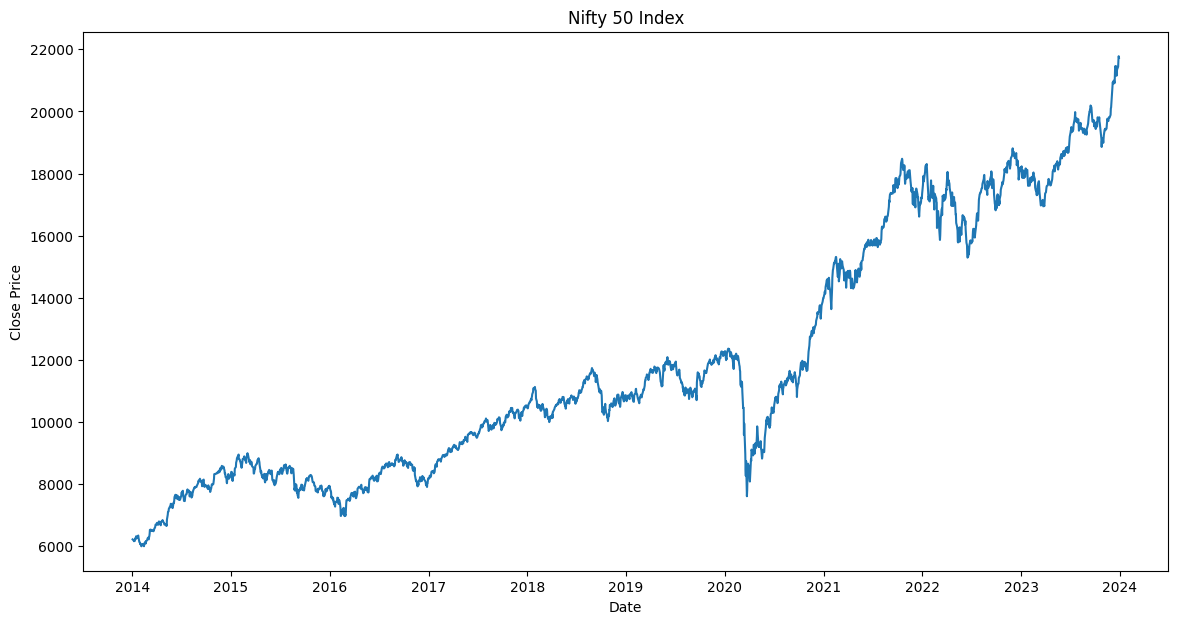

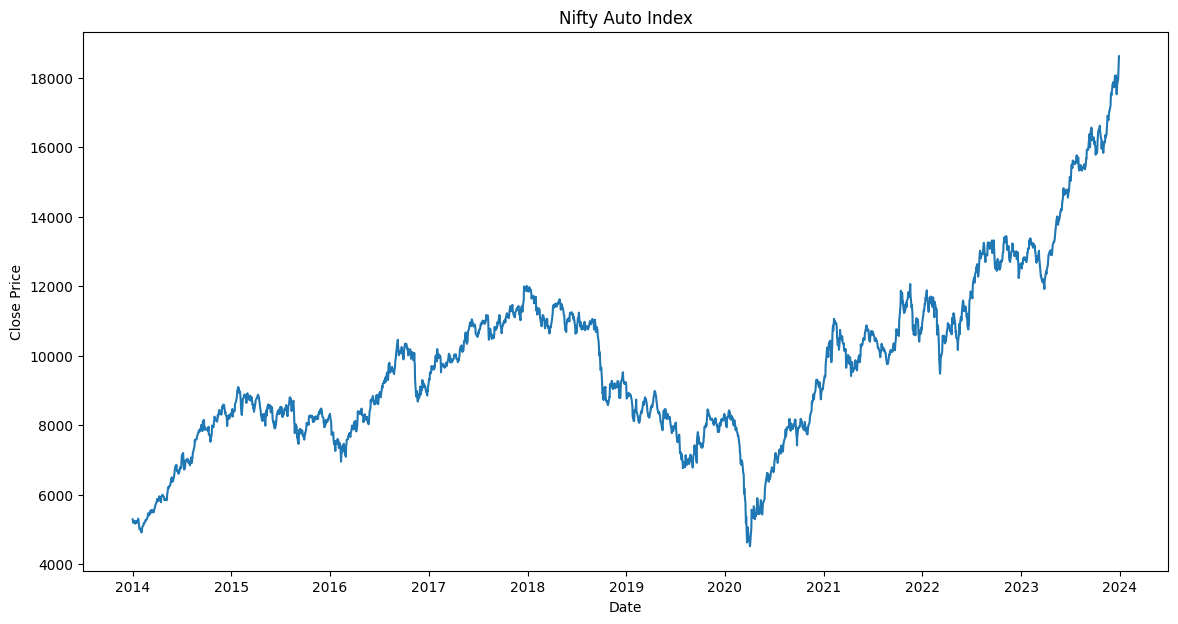

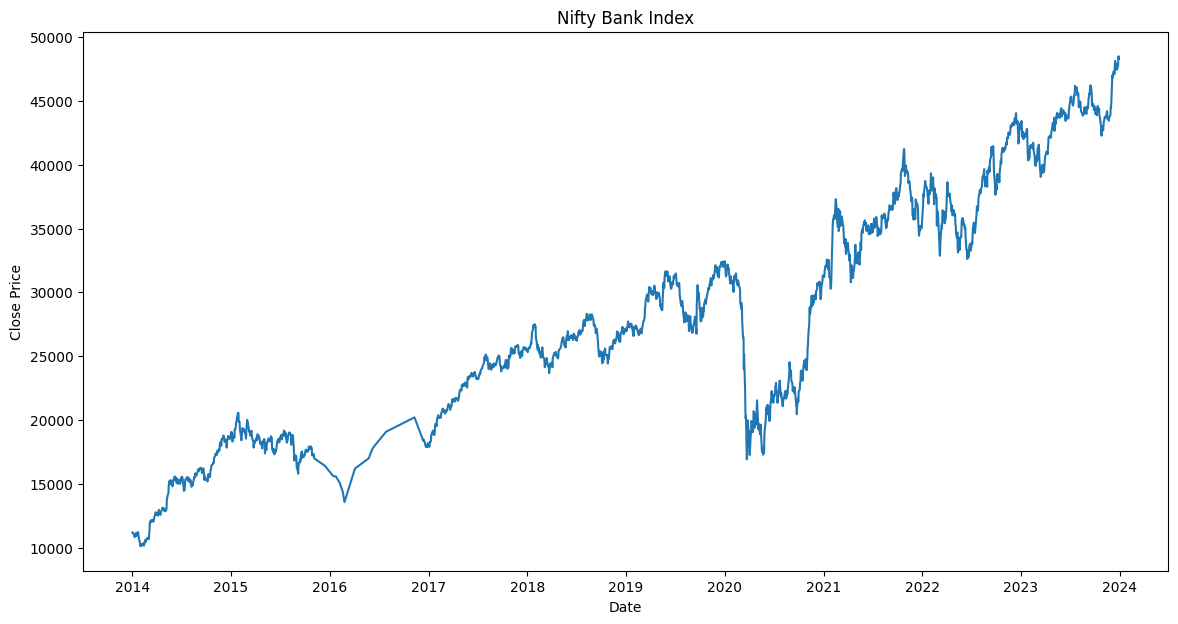

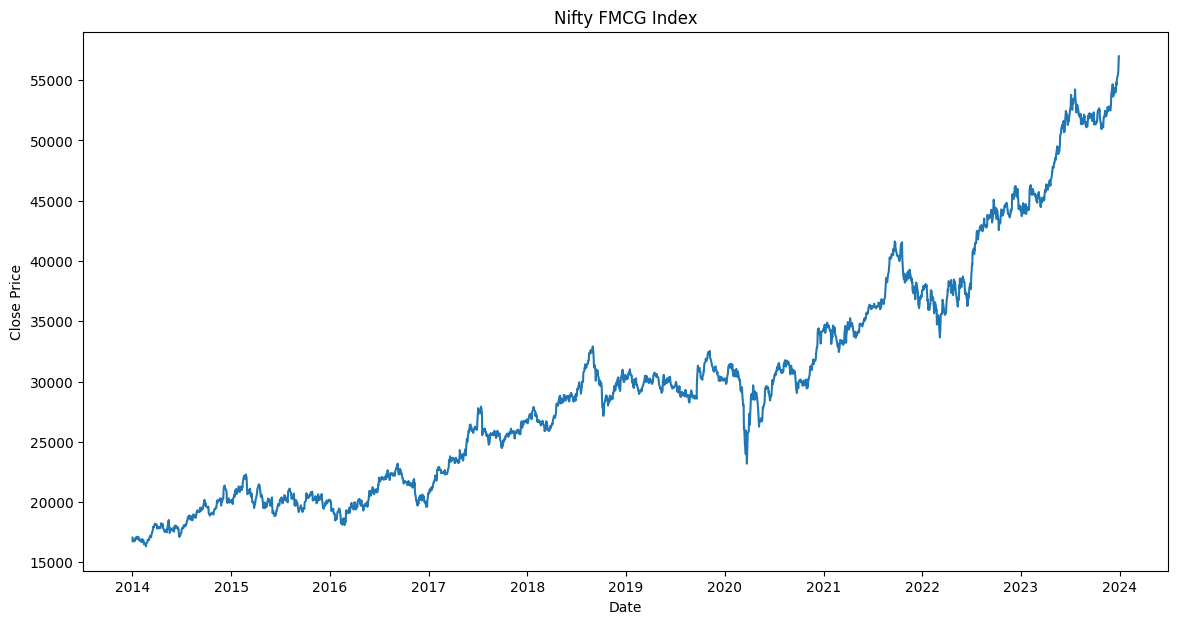

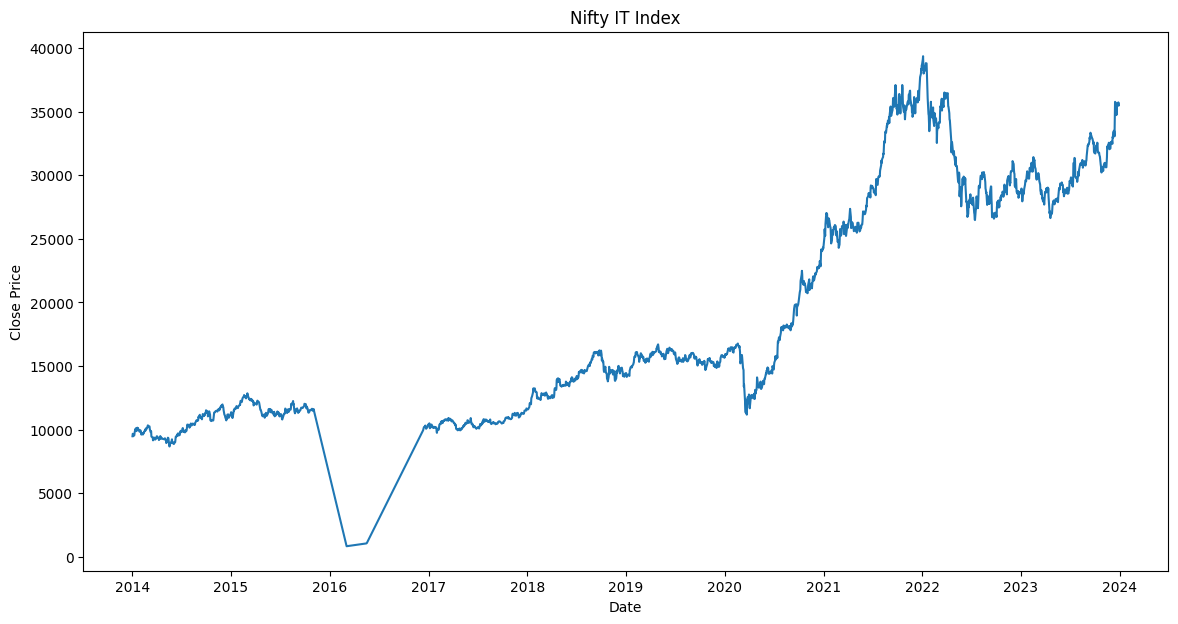

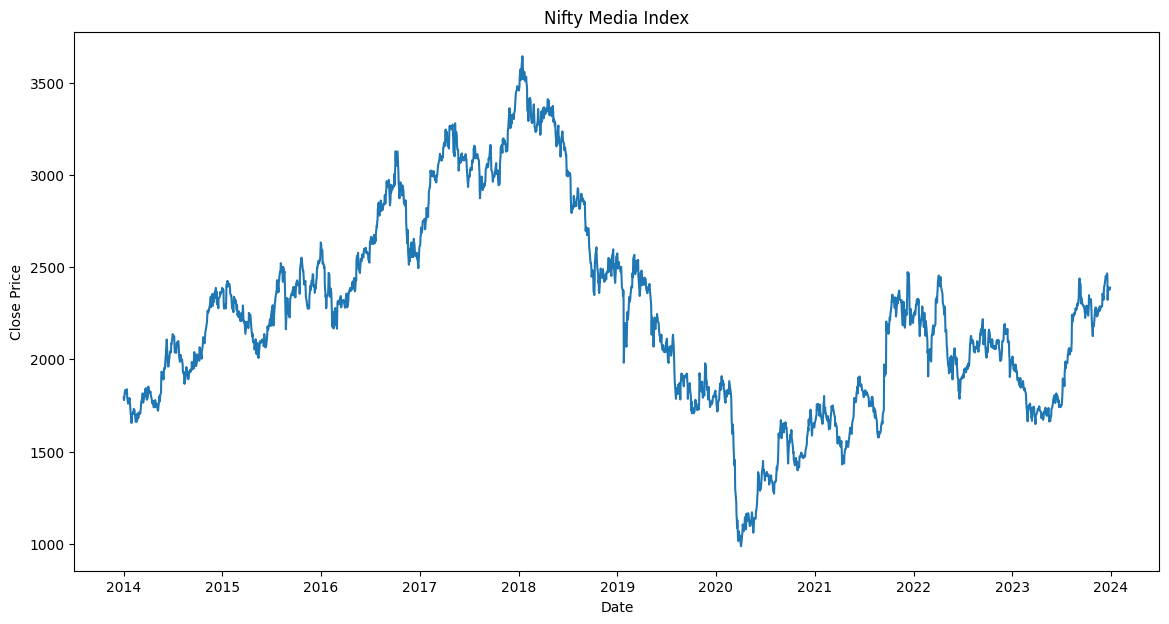

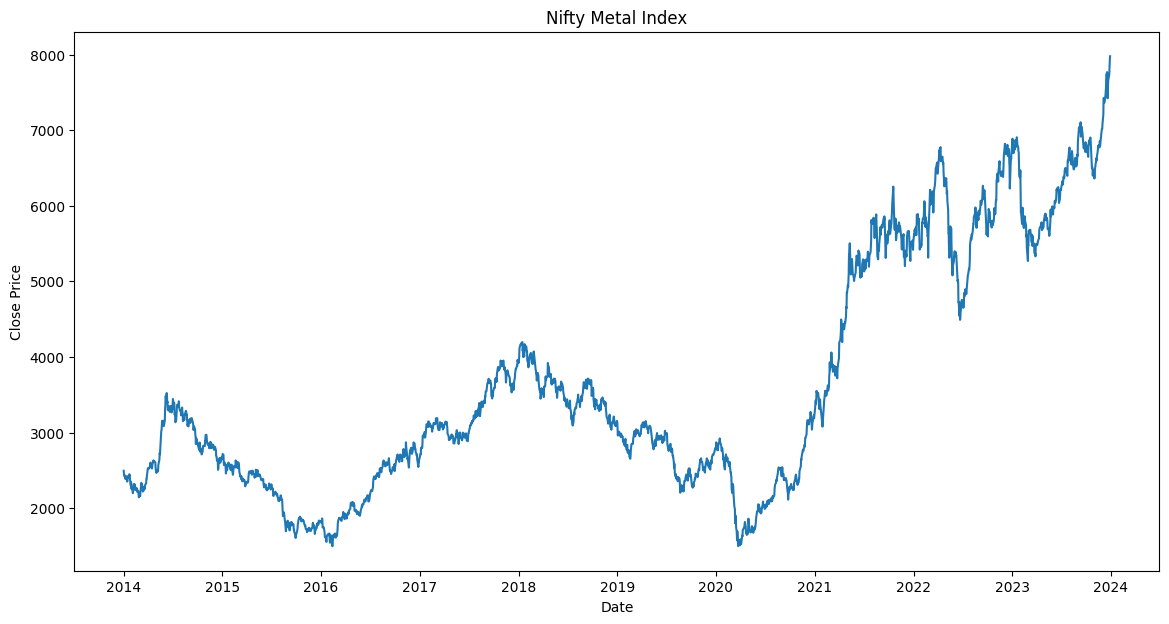

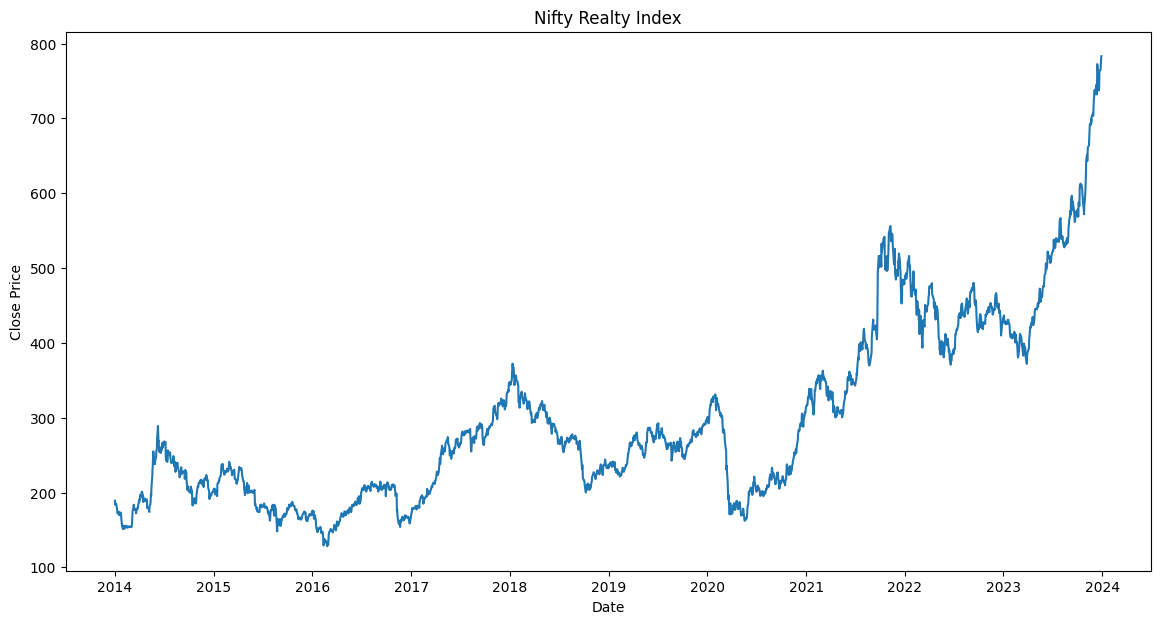

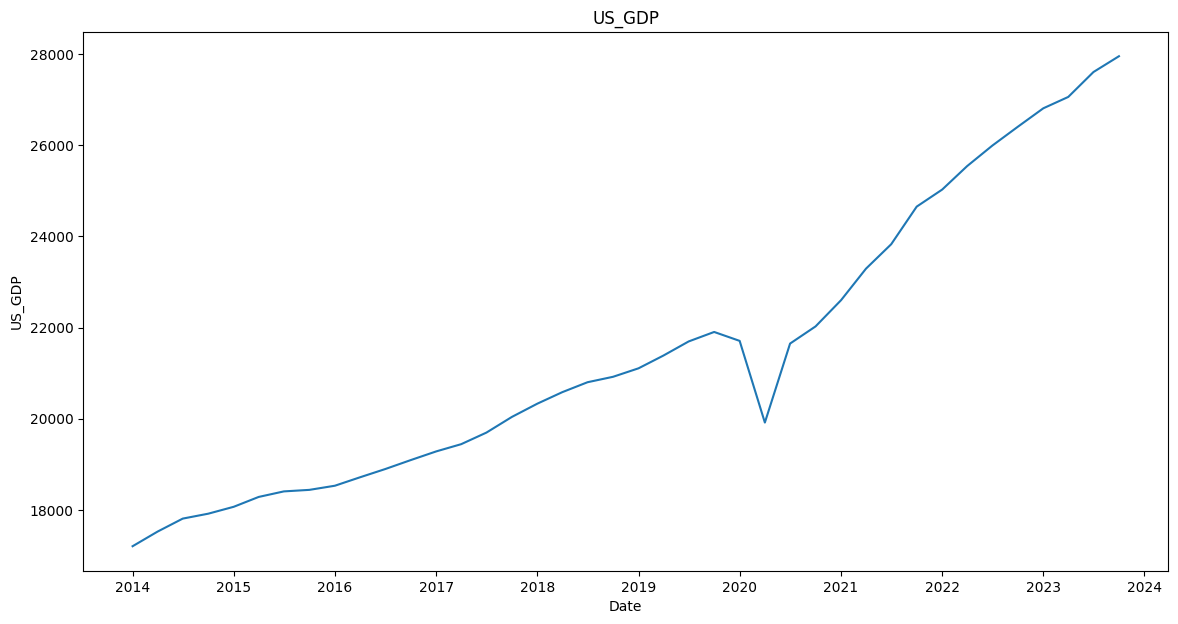

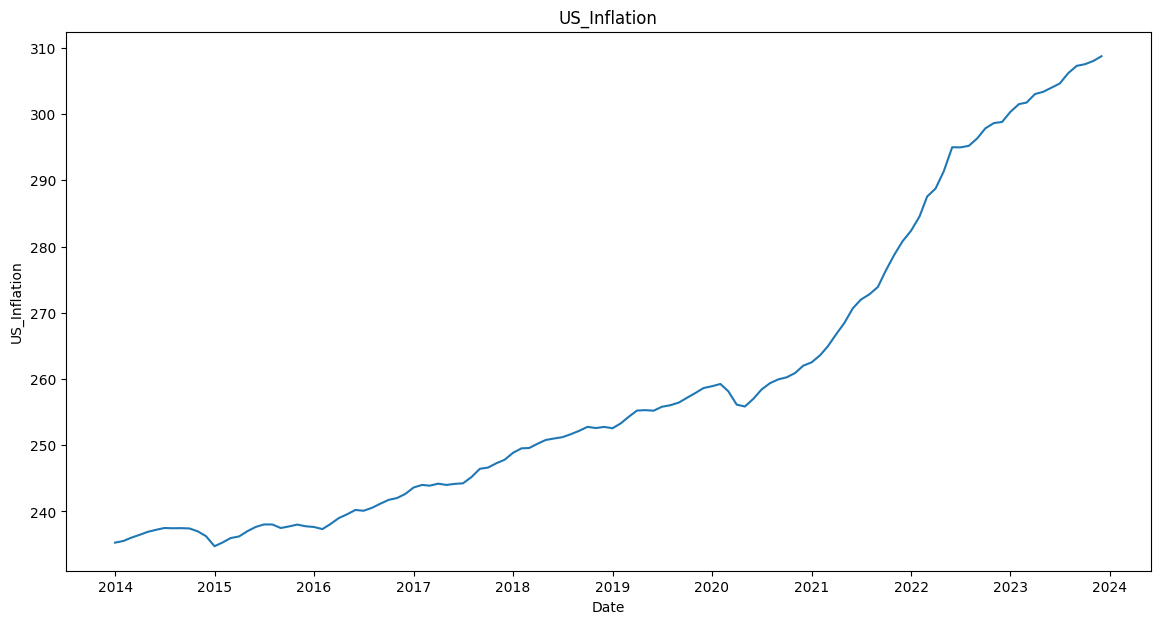

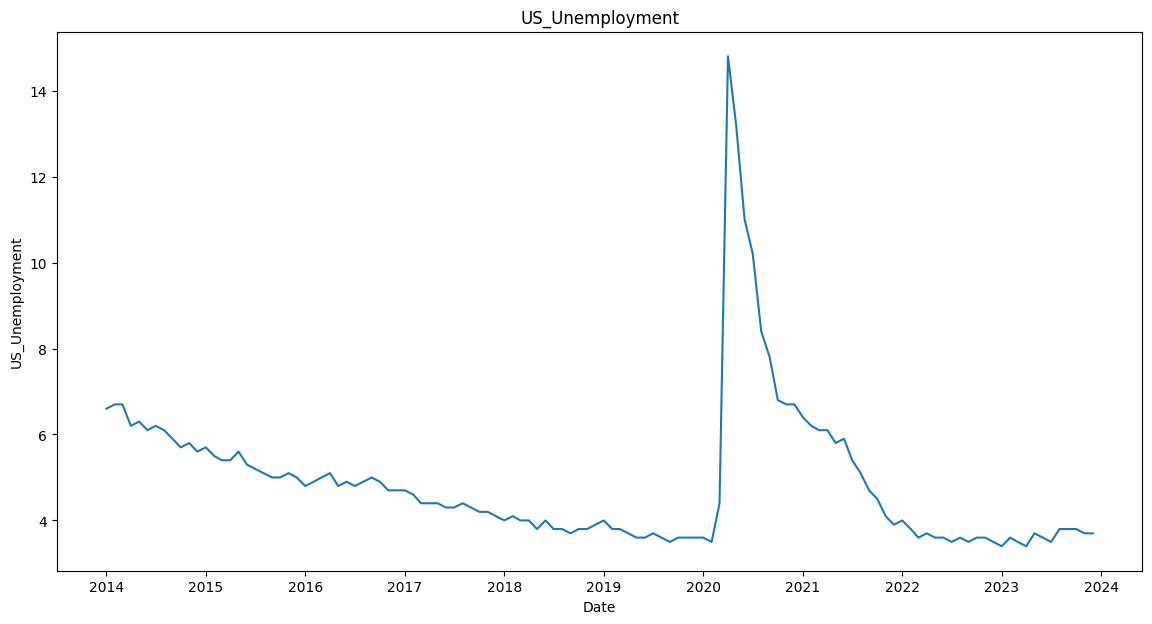

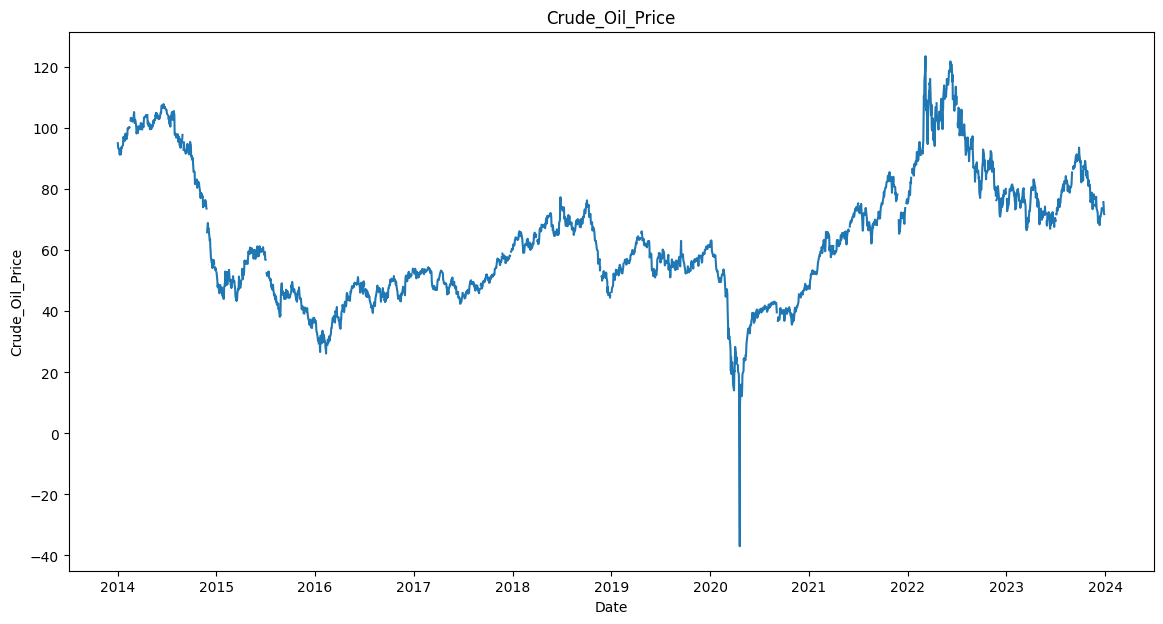

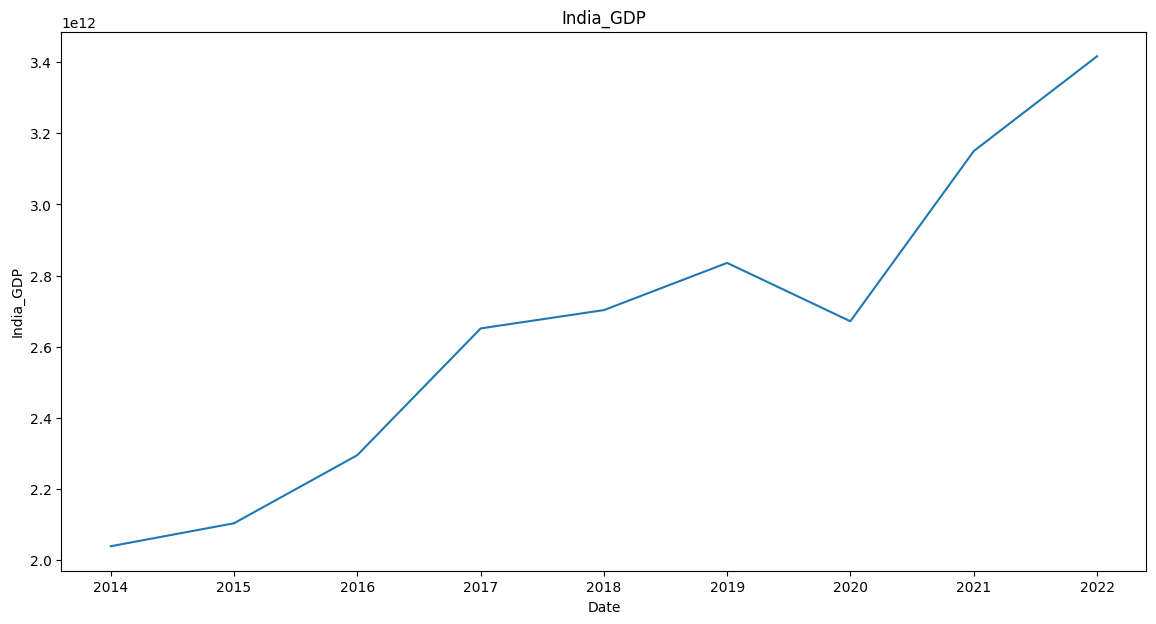

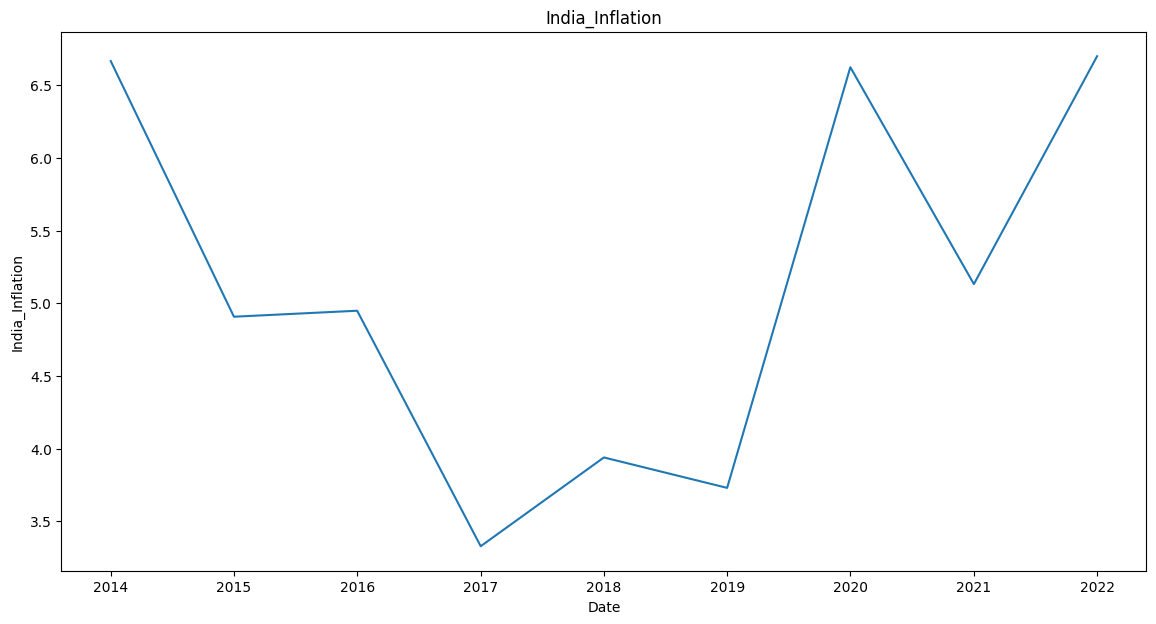

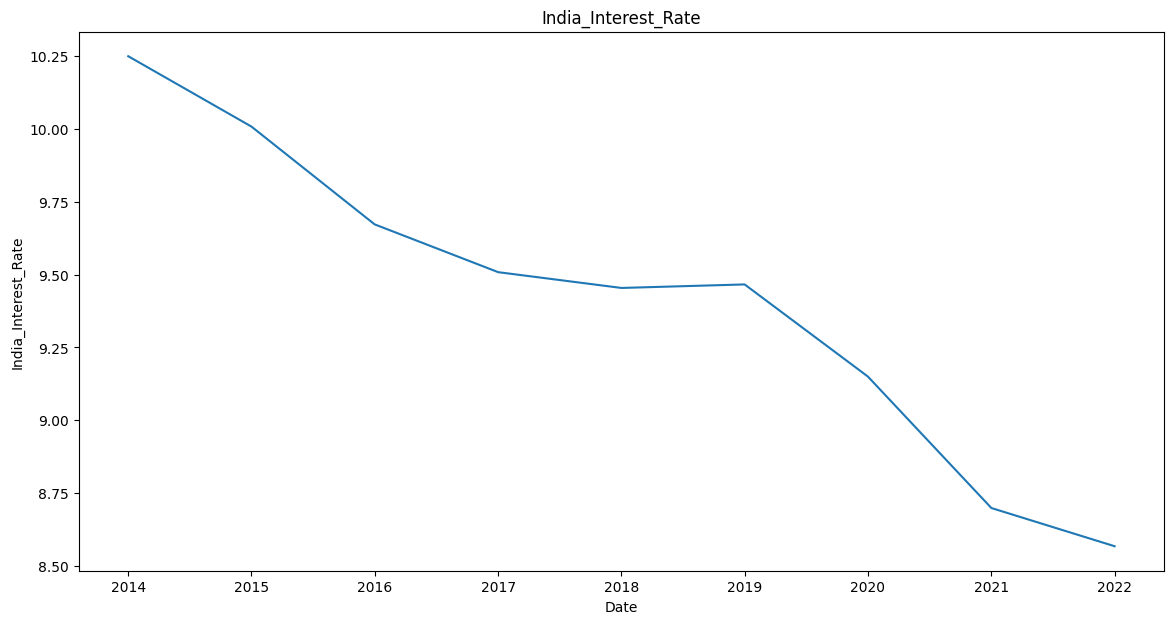

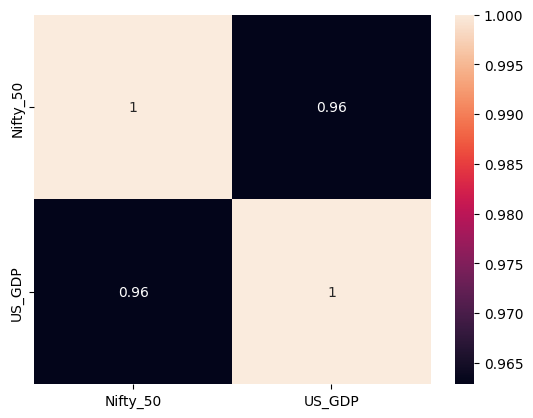

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Nifty sector data
nifty_data = {}
for name in nifty_indices.keys():
    df = pd.read_csv(f'{name}_data.csv', index_col='Date', parse_dates=True)
    nifty_data[name] = df

# Load macroeconomic data
macro_data = {}
for var in fred_vars.keys():
    df = pd.read_csv(f'{var}_data.csv', index_col='DATE', parse_dates=True)
    macro_data[var] = df
india_macro_data = pd.read_csv('India_macro_data.csv', index_col='year', parse_dates=True)
for col in india_macro_data.columns:
    macro_data[col] = india_macro_data[col]

# Plot Nifty sector indices
for name, df in nifty_data.items():
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'])
    plt.title(f'{name} Index')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

# Plot macroeconomic variables
for var, df in macro_data.items():
    plt.figure(figsize=(14, 7))
    plt.plot(df)
    plt.title(var)
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.show()

# Correlation analysis
combined_data = pd.concat([nifty_data['Nifty 50']['Close'], macro_data['US_GDP']], axis=1).dropna()
combined_data.columns = ['Nifty_50', 'US_GDP']
sns.heatmap(combined_data.corr(), annot=True)
plt.show()


Putting our data collected into training by applying random forest regressor to it to decide which sector will outperform Nifty-50.
Also applied feature engineering using lagged feature to optimise the model.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def prepare_data(nifty_data, macro_data):
    df = nifty_data[['Close']].copy()
    for var, data in macro_data.items():
        df = df.merge(data, left_index=True, right_index=True, how='left')
    
    # Handle missing values
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    # Feature engineering: create lagged features
    lags = 12
    lagged_features = pd.concat([df.shift(lag).add_suffix(f'_lag_{lag}') for lag in range(1, lags + 1)], axis=1)
    df = pd.concat([df, lagged_features], axis=1)
    
    # Drop rows with NaN values after creating lagged features
    df.dropna(inplace=True)
    
    return df

# Prepare data for each Nifty sector
sector_data = {}
for name, data in nifty_data.items():
    sector_data[name] = prepare_data(data, macro_data)

# Train models and make predictions
predictions = {}
for name, df in sector_data.items():
    X = df.drop(columns=['Close'])
    y = df['Close']
    
    # Check if data is sufficient for the specified test size
    if len(X) <= 1:
        print(f"Skipping {name} due to insufficient data.")
        continue
    
    # Split the data into training and test sets
    test_size = min(0.2, len(X) - 1)  # Ensure test size is not larger than available data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    predictions[name] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'mse': mean_squared_error(y_test, y_pred)
    }

# Compare sector predictions to Nifty 50
nifty_pred = predictions['Nifty 50']['y_pred']
outperformance = {}
for name in sector_data.keys():
    if name != 'Nifty 50' and name in predictions:  # Check if predictions exist for the sector
        sector_pred = predictions[name]['y_pred']
        outperformance[name] = sector_pred.mean() > nifty_pred.mean()

# Display the sectors that are predicted to outperform the Nifty 50
outperforming_sectors = [name for name, outperforms in outperformance.items() if outperforms]
print("Sectors predicted to outperform Nifty 50:", outperforming_sectors)


Skipping Nifty Bank due to insufficient data.
Skipping Nifty IT due to insufficient data.
Sectors predicted to outperform Nifty 50: ['Nifty FMCG']


This is how we predicted that Nifty FMCG would outperform Nifty 50 in the test years.
Below are some visualisations to provide clear understanding on why we say that Nifty FMCG would be outperforming Nifty 50

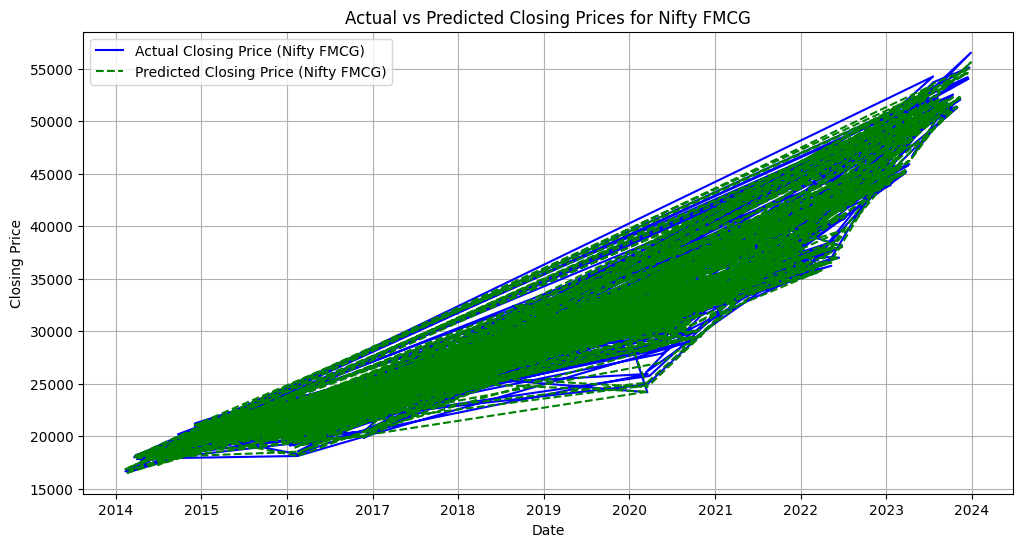

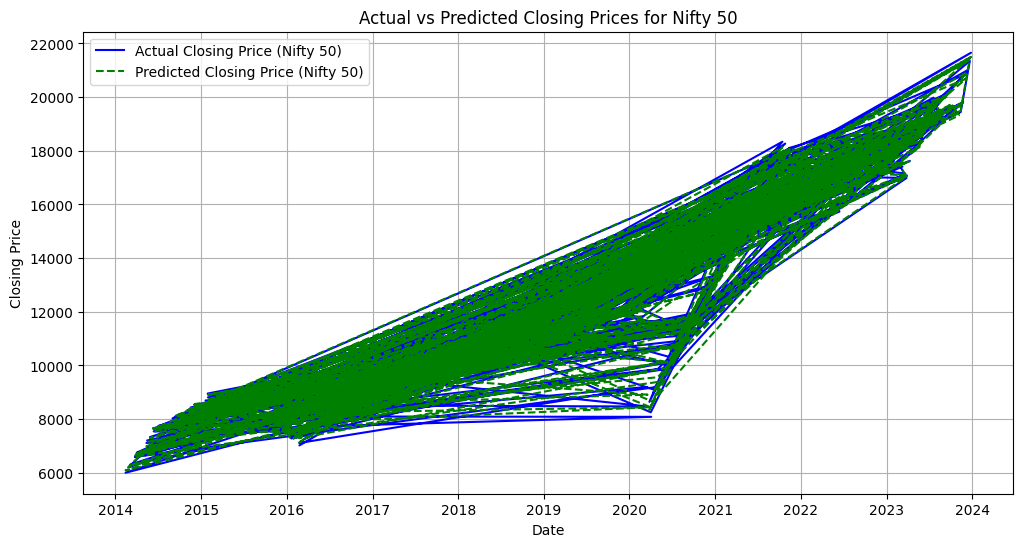

In [4]:
import matplotlib.pyplot as plt

# Get actual and predicted closing prices for Nifty FMCG
actual_prices_fmcg = predictions['Nifty FMCG']['y_test']
predicted_prices_fmcg = predictions['Nifty FMCG']['y_pred']

# Get actual and predicted closing prices for Nifty 50
actual_prices_nifty50 = predictions['Nifty 50']['y_test']
predicted_prices_nifty50 = predictions['Nifty 50']['y_pred']

# Plot actual vs predicted closing prices for Nifty FMCG
plt.figure(figsize=(12, 6))
plt.plot(actual_prices_fmcg.index, actual_prices_fmcg, label='Actual Closing Price (Nifty FMCG)', color='blue')
plt.plot(actual_prices_fmcg.index, predicted_prices_fmcg, label='Predicted Closing Price (Nifty FMCG)', linestyle='--', color='green')
plt.title('Actual vs Predicted Closing Prices for Nifty FMCG')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted closing prices for Nifty 50
plt.figure(figsize=(12, 6))
plt.plot(actual_prices_nifty50.index, actual_prices_nifty50, label='Actual Closing Price (Nifty 50)', color='blue')
plt.plot(actual_prices_nifty50.index, predicted_prices_nifty50, label='Predicted Closing Price (Nifty 50)', linestyle='--', color='green')
plt.title('Actual vs Predicted Closing Prices for Nifty 50')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


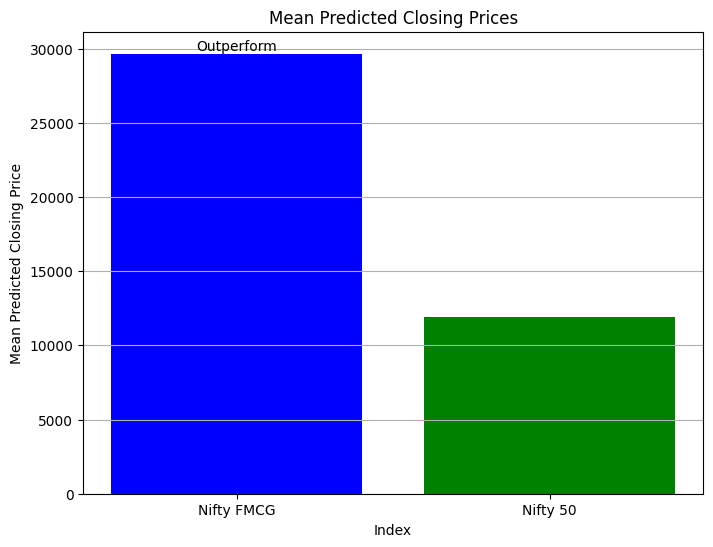

In [5]:
# Calculate the mean predicted closing prices for Nifty FMCG and Nifty 50
mean_pred_fmcg = predicted_prices_fmcg.mean()
mean_pred_nifty50 = predicted_prices_nifty50.mean()

# Plot the mean predicted closing prices
plt.figure(figsize=(8, 6))
plt.bar(['Nifty FMCG', 'Nifty 50'], [mean_pred_fmcg, mean_pred_nifty50], color=['blue', 'green'])
plt.title('Mean Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Mean Predicted Closing Price')
plt.grid(axis='y')

# Add text to show which index is predicted to outperform
if mean_pred_fmcg > mean_pred_nifty50:
    plt.text(0, mean_pred_fmcg, 'Outperform', ha='center', va='bottom')
else:
    plt.text(1, mean_pred_nifty50, 'Outperform', ha='center', va='bottom')

plt.show()
